In [1]:
import os
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
import pims
from pathlib import Path
from mpl_toolkits.mplot3d import Axes3D
from skimage.io import imsave
from skimage.measure import regionprops
import trackpy as tp
from scipy.signal import spectrogram, periodogram,savgol_filter
from scipy.signal import find_peaks
import pg_analysis.plotter as pga
import pg_analysis
from scipy.stats import skew
from scipy.signal import find_peaks
from pg_analysis import style
plt.style.use('~/Code/AnalysisNotebooksMKS/NIFStyle.mplstyle')
import matplotlib as mpl
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=plt.get_cmap('tab10').colors)

In [123]:
def chunk_mean(tmp, tau, time_coordinate='frame'):
    """coarse-grain data and average over chunks"""
    t_bins = np.arange(tmp[time_coordinate].min(), tmp[time_coordinate].max(), tau+1)
    _t = np.digitize(tmp[time_coordinate], t_bins)
    return tmp.groupby(_t).mean()

def chunk_max(tmp, tau, time_coordinate='frame'):
    """coarse-grain data and average over chunks"""
    t_bins = np.arange(tmp[time_coordinate].min(), tmp[time_coordinate].max(), tau+1)
    _t = np.digitize(tmp[time_coordinate], t_bins)
    return tmp.groupby(_t).max()

def add_cbar(ax, im, label=''):
    cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.02,ax.get_position().height])
    plt.colorbar(im, cax=cax, label = label)


# Longterm calcium activity tracking

This script reads in data generated with https://github.com/scholz-lab/MacroscopeDataAnalysis


In [3]:
units = {'x': 'cm',
 'y': 'cm',
 'frame': 1,
 'pumps': 'a.f.u.',
 'signal_mean': 'a.f.u.',
         'signal_max': 'a.f.u.',
         'time':'s',
 "velocity":"um/s",
 'Istd': 'a.f.u.',
 'Centerline': '1',
 'Straightened': 1,
 'area': 'px^2',
 'temperature': 'C',
 'humidity': '%',
 "reversals_nose":1,
 "reversal_events_nose":1,
 'size': 'mm',
 'age': 'h',
 '@acclimation': 'min',
'Imean':'a.f.u'}

In [4]:
# here we have centerlines
path = '/gpfs/soma_fs/home/scholz/scratch/gcamp8_longterm/test_script'
# # here we have raw tracking coordinate files
# raw_data_path = '/gpfs/soma_fs/nif/nif9201.bak/Euphrasie/1_rawdata_tracking/Projects/Macroscope_paper/1h_GCamp8f_OnFood/'

#folders = ['EROnFoodWT017', 'EROnFoodWT035', 'EROnFoodWT050', 'EROnFoodWT066', 'EROnFoodWT065', 'EROnFoodWT068']
cols = ['time','signal_mean', 'signal_max', 'frame', 'x', 'y']

In [5]:
control = pga.Experiment(strain='INF418', condition='OnFood', scale=1, fps = 30) # pga.Experiment is the class (object). control is the instance/variable. It's a specific realization of an experimental setup based on the pga.Experiment class. control has its own unique characteristics (e.g., strain, condition_)
control.load_data(path, units=units, filterword = 'signals', particle_index=1, columns = cols) # loading data into the control object.

Reading /gpfs/soma_fs/home/scholz/scratch/gcamp8_longterm/test_script/EROnFoodWT035_signals.json
Reading /gpfs/soma_fs/home/scholz/scratch/gcamp8_longterm/test_script/EROnFoodWT068_signals.json
Reading /gpfs/soma_fs/home/scholz/scratch/gcamp8_longterm/test_script/EROnFoodWT066_signals.json
Reading /gpfs/soma_fs/home/scholz/scratch/gcamp8_longterm/test_script/EROnFoodWT017_signals.json
Reading /gpfs/soma_fs/home/scholz/scratch/gcamp8_longterm/test_script/EROnFoodWT065_signals.json
Reading /gpfs/soma_fs/home/scholz/scratch/gcamp8_longterm/test_script/EROnFoodWT062_signals.json
Reading /gpfs/soma_fs/home/scholz/scratch/gcamp8_longterm/test_script/EROnFoodWT050_signals.json
Reading /gpfs/soma_fs/home/scholz/scratch/gcamp8_longterm/test_script/EROnFoodWT060_signals.json


In [23]:
for w in control.samples:
    print(len(w.data))

108000
108000
108000
108000
108000
10


In [26]:
control.samples.pop(5)

Worm 
 with underlying data:           frame     index       time  signal_mean  signal_max             x  \
count  10.00000  10.00000  10.000000    10.000000   10.000000     10.000000   
mean    4.50000   4.50000   0.150000    31.882954   99.600000  65631.085929   
std     3.02765   3.02765   0.100922     6.485026   26.069139      5.668280   
min     0.00000   0.00000   0.000000    21.017077   53.000000  65622.645448   
25%     2.25000   2.25000   0.075000    27.036820   81.500000  65626.387361   
50%     4.50000   4.50000   0.150000    33.703070  106.000000  65632.184444   
75%     6.75000   6.75000   0.225000    37.100747  118.500000  65635.116749   
max     9.00000   9.00000   0.300000    38.349701  127.000000  65639.139668   

                  y      x_scaled      y_scaled  
count     10.000000     10.000000     10.000000  
mean   69703.361967  65631.085929  69703.361967  
std        9.439764      5.668280      9.439764  
min    69688.528608  65622.645448  69688.528608  
25%    69

## Load centerlines for each worm

In [27]:
# load centerlines separately
npts = 100 # this should match the nPts given in the parameter file for the analysis.
for worm in control.samples:
    centerlinepath = Path(path) /  f"{worm.experiment.split('_')[0]}_um_centerlines.csv"
    centerlines = np.genfromtxt(centerlinepath, delimiter=',')
    centerlines = np.reshape(centerlines, (centerlines.shape[0], npts, 2))
    worm.centerline = centerlines

In [28]:
control

Experiment 
 Strain: INF418,
 Condition: OnFood
 N = 5.

In [29]:
centerlines.T.shape

(2, 100, 108000)

## interpolate signals

(80.0, 200.0)

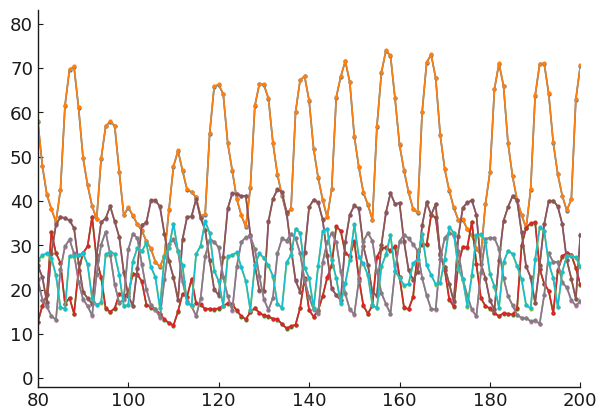

In [30]:
# interpolate data

# y = control.get_sample_metric(key='signal_mean', metric=None)[:3000]
# plt.plot(y['signal_mean_5'])
# plt.xlim(50,100)
    

for wi, worm in enumerate(control.samples):
    dat = worm.data
    idx = pd.Index(np.arange(dat['frame'].min(), dat['frame'].max()+1), name="frame")
    dat = dat.set_index("frame").reindex(idx).reset_index()
    plt.plot(dat['frame'], dat['signal_mean'], '.-')
    dat = dat.interpolate()
    plt.plot(dat['frame'],dat['signal_mean']+0.1, '.-')
    control.samples[wi].data = dat

#y = control.get_sample_metric(key='signal_mean', metric=None)[:3000]
# plt.plot(y['signal_mean_5']+1)
plt.xlim(80,200)
    
    

## calculate velocity and reversals
note: as x,y are already in um, set the scale to 1 in the loading function:  
`control = pga.Experiment(strain='INF418', condition='OnFood', scale=1, fps = 30)`

In [31]:
## calculate properties

# calculate extra stuff
ppars = {'sensitivity' : 0.999, 'min_distance' : 4, 'adaptive_window':120, 'min_prominence':1}
control.calculate_property('time') # uses fps to get frame -> seconds
control.calculate_property('locations')
control.calculate_property('velocity', dt=15)
control.calculate_property('smoothed', key='velocity', window=300, aligned = False)
control.calculate_property("reversals", angle_threshold=100, animal_size=200)
control.calculate_property("reversals_nose",dt =15, angle_threshold = 150, w_smooth = 30, min_duration = 30)

/gpfs/soma_fs/home/scholz/Code/Pharaglow-Analysis/pg_analysis/plotter.py:470: RuntimeWarning: invalid value encountered in double_scalars
  return np.degrees(np.arccos(np.dot(v1, v2)/np.linalg.norm(v1)/np.linalg.norm(v2)))
/gpfs/soma_fs/home/scholz/Code/Pharaglow-Analysis/pg_analysis/plotter.py:470: RuntimeWarning: invalid value encountered in double_scalars
  return np.degrees(np.arccos(np.dot(v1, v2)/np.linalg.norm(v1)/np.linalg.norm(v2)))
/gpfs/soma_fs/home/scholz/Code/Pharaglow-Analysis/pg_analysis/plotter.py:470: RuntimeWarning: invalid value encountered in double_scalars
  return np.degrees(np.arccos(np.dot(v1, v2)/np.linalg.norm(v1)/np.linalg.norm(v2)))
/gpfs/soma_fs/home/scholz/Code/Pharaglow-Analysis/pg_analysis/plotter.py:470: RuntimeWarning: invalid value encountered in double_scalars
  return np.degrees(np.arccos(np.dot(v1, v2)/np.linalg.norm(v1)/np.linalg.norm(v2)))
/gpfs/soma_fs/home/scholz/Code/Pharaglow-Analysis/pg_analysis/plotter.py:470: RuntimeWarning: invalid value 

In [32]:
control.calculate_property("reversals_nose",dt =15, angle_threshold = 150, w_smooth = 30, min_duration = 15)

In [33]:
control.samples[5].data

IndexError: list index out of range

In [55]:
ppars = {'sensitivity' : 0.999, 'min_distance' : 4, 'adaptive_window':120, 'min_prominence':0.25, 'use_pyampd':True}
control.calculate_property("preprocess_signal", key='signal_mean', w_outlier=None, w_bg=300, w_smooth=1)
control.calculate_property("pumps", key='signal_mean_clean', **ppars)
control.calculate_property("count_rate", key='pump_events', window=300)
control.calculate_property('smoothed', key='count_rate_pump_events', window=300, aligned = False)

/gpfs/soma_fs/home/scholz/Code/Pharaglow-Analysis/pg_analysis/tools.py:65: PeakPropertyWarning: some peaks have a prominence of 0
  prom,_,_  = peak_prominences(signal, peaks, wlen)


In [56]:
# time-align all to their starting point
for worm in control.samples:
    worm.create_ID()
    t0 = worm.data.frame.min()
    try:
        #t0 = worm.data.frame[np.where(worm.data.reversal_events_nose==1)[0][0]]
        worm.multi_align(timepoints=[t0], tau_before=0, tau_after=30*60*60*1, 
                           key = None, column_align = 'frame')
    except IndexError:
        pass

## Centerline Figure

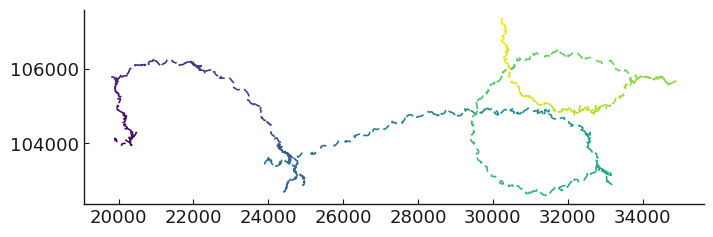

In [57]:
# plot contour over time.
#NOTE: NEED CALIBRATION matrix to make this correct. Current one is ok
mat = np.identity(2)
mat = [[1,0],[0,-1]]
wid = 4#wormid
t0 = 1500
maxt = 15000
dt = 60
times = np.arange(t0, maxt, dt)
cmap = plt.cm.viridis
plt.figure(figsize=(8,8))
plt.gca().set_aspect( 1)
for t in times:
    #cp = contour[t].T
    cp = control.samples[wid].centerline[t]
    cp = mat @ cp.T
    x,y = control.samples[wid].data.x, control.samples[wid].data.y
    plt.plot(cp[0]+x[t], cp[1]+y[t], color=cmap((t-t0)/(maxt-t0)))
#plt.plot(x[t0:maxt], y[t0:maxt], color='k', zorder=-1)
#plt.savefig(f'{movie}_{t0}_{maxt}_dt={dt}_contours.svg')

## Figures

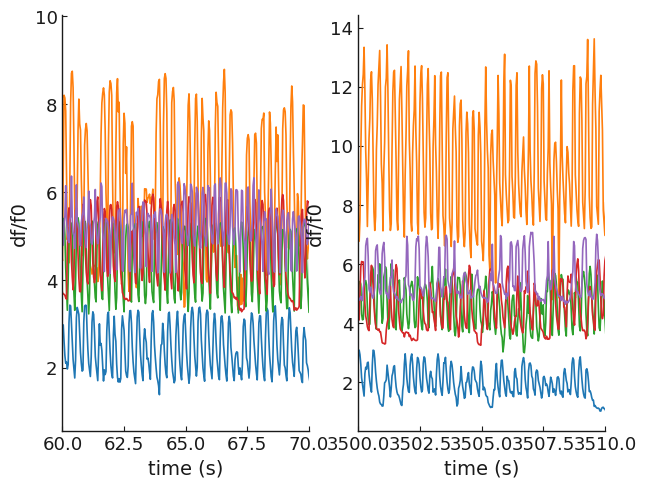

In [58]:
f, axes = plt.subplots(1,2, figsize=(7,5.5))
y = control.get_sample_metric(key='signal_mean', metric=None)[:3000]
y/= y.min()
x = pd.DataFrame([y.index]*len(control)).T[:3000]/control.fps
pumps = control.get_sample_metric('pump_events', metric=None)[:3000]
y = y.values+np.linspace(0,3,len(control))
axes[0].plot(x.values,y)
#axes[0].scatter(x.values[np.where(pumps==1)], y[np.where(pumps==1)], color='r')
axes[0].set_xlim(60,70)
#plt.xlim(2600,2900)
tmax = 60*30*30
y = control.get_sample_metric(key='signal_mean', metric=None)[-6000:]
y/= y.min()
x = pd.DataFrame([y.index]*len(control)).T[-6000:]/control.fps
pumps = control.get_sample_metric('pump_events', metric=None)[-6000:]
y = y.values+np.linspace(0,3,len(control))
axes[1].plot(x.values,y)
#axes[1].scatter(x.values[np.where(pumps==1)], y[np.where(pumps==1)])
axes[1].set_xlim(3500,3510)
plt.setp(axes, ylabel='df/f0', xlabel='time (s)')
plt.savefig('figures/Start_end_signal.svg')


In [59]:
pwd

'/gpfs/soma_fs/scratch/mscholz/gcamp8_longterm'

## Generate bleaching curves

In [60]:
def exp(x, a,t):
    y = a*np.exp(-x/t)#+b
    return y
    
    
from sklearn.metrics import r2_score#(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average', force_finite=True)
from scipy.optimize import curve_fit#(f, xdata, ydata, p0=None, sigma=None, absolute_sigma=False, check_finite=None, bounds=(-inf, inf), method=None, jac=None, *, full_output=False, nan_policy=None, **kwargs)


0.858474834769163 [  0.97259387 240.3022145 ]


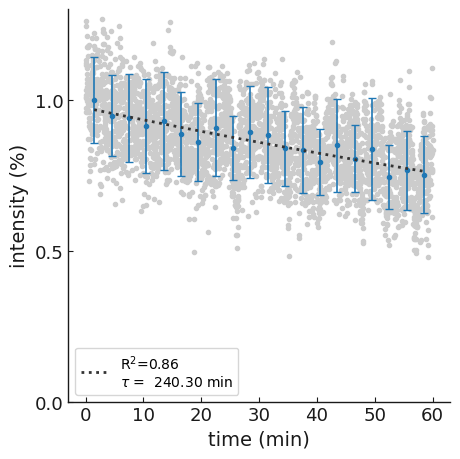

In [61]:
signal = control.get_aligned_sample_metric( 'signal_max')
time_original = control.get_aligned_sample_metric( 'time_align', metric_sample='mean')/60 # in minutes

signal['time'] = time_original
# average over a minute
signal_coarse = chunk_mean(signal, 2, time_coordinate='time')
# drop time
time = signal_coarse['time']
signal_coarse = signal_coarse.drop('time',axis=1)
signal = signal.drop('time',axis=1)
# normalize
signal /= signal_coarse.iloc[0].mean()#.mean(axis=1)
signal_coarse /= signal_coarse.iloc[0].mean()#.mean(axis=1)
intensity=signal_coarse.mean(axis=1)
intensity_err = signal_coarse.std(axis=1)/np.sqrt(len(signal_coarse.columns))

fig, axes = plt.subplots(1,1, figsize=(4.7,4.7))
plt.scatter(time_original[::30], signal.mean(axis=1)[::30], color='0.8')
plt.errorbar(time,intensity, yerr=intensity_err , mew=1,capsize=3, linestyle="None", marker='.')
plt.setp(plt.gca(), xlabel='time (min)', ylabel='intensity (%)', yticks=[0,0.5,1], ylim=[0,1.3])

popt, _ = curve_fit(exp, p0=[10,500],xdata = time, ydata = intensity)#, sigma= intensity_err)
r2 = r2_score(intensity, exp(np.array(time), *popt))
print(r2, popt)
plt.plot(time, exp(time, *popt), color='0.2', zorder=10, linestyle=':', lw=2, label=fr'R$^2$={r2:.2f}'' \n$'rf'\tau$ =  {popt[1]:.2f} min')
plt.legend()
plt.tight_layout()
plt.savefig('figures/Bleaching_curve.svg')

## Density plots

0.024944444444444443 1.0


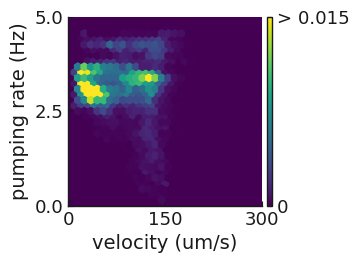

In [65]:

fig, axes = plt.subplots(1,1, figsize=(2.5,2.5))
loc = 0
#axes = axes.ravel()
axes = [axes]
vmax = 0.015
cm = plt.cm.viridis

#plot, x, y = data[condition][:].plot(axes, ('velocity', 'count_rate'), metric = 'collapse', plot_type = 'scatter',alpha=0.001 )
x = control.get_sample_metric('velocity_smooth', metric = 'collapse', axis=0)
y = control.get_sample_metric('count_rate_pump_events_smooth', metric = 'collapse', axis=0)

# clean nans in the data
tmp = pd.concat([x, y], axis=1)
tmp = tmp.dropna()


#axes[loc].plot(x[::30], y[::30], '^', alpha=0.05)
hb = axes[loc].hexbin(tmp.iloc[:,0], tmp.iloc[:,1], extent = [0,300,0,5], gridsize=30)
hb = axes[loc].hexbin(tmp.iloc[:,0], tmp.iloc[:,1], C=np.ones(len(tmp), dtype=float)/hb.get_array().sum(), 
                      extent = [0,300,0,5], gridsize=30, cmap=cm, reduce_C_function=np.sum, vmax = vmax, vmin =0)
print(hb.get_array()[20:-20].max(), hb.get_array().sum())
# normalize

#         axes[loc].plot(x.mean(), y.mean(), 'ro', markersize=3)
#         axes[loc].errorbar(x.mean(), y.mean(), xerr = x.std(), yerr= y.std(), markersize=10,color = 'w')
#         #plot, x, y = data[condition][:100].plot(axes, ('velocity', 'count_rate'), metric = 'mean', plot_type = 'scatter')
#         slope, intercept, r_value, p_value, stderr= stats.linregress(x=x[::30].values[:,0], y=y[::30].values[:,0])
#         print(condition, 'R=',f'{r_value**2:.2f}')
ax = axes[-1]
cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.02,ax.get_position().height])
cbar = plt.colorbar(hb, cax=cax, ticks=[0,  vmax]) # Similar to fig.colorbar(im, cax = cax)

plt.setp(axes[::2],  ylabel='pumping rate (Hz)');
plt.setp(axes[-2:], xlabel='velocity (um/s)');
plt.setp(axes,xlim=(0,300), ylim=(0,5), yticks=[0,2.5,5], xticks=[0,150,300]);
#fig.colorbar(cbar, ticks=[0,  vmax])
cbar.ax.set_yticklabels(['0',  f'> {vmax}'])  # vertically oriented colorbar
#plt.savefig('On_food_30min_density_Celegans.svg', bbox_inches='tight')
plt.savefig('figures/Longterm_behavior_correlation_1s_dt.svg')

## Scatter plots

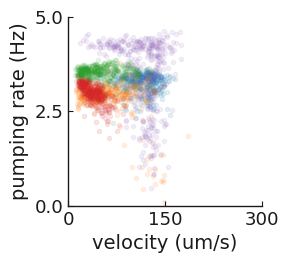

In [66]:
fig, axes = plt.subplots(1,1, figsize=(2.5,2.5))
#axes = axes.ravel()
axes = [axes]
vmax = 0.015
cm = plt.cm.viridis

#plot, x, y = data[condition][:].plot(axes, ('velocity', 'count_rate'), metric = 'collapse', plot_type = 'scatter',alpha=0.001 )
x = control.get_aligned_sample_metric('velocity_smooth')#, metric = 'None', axis=0)
y = control.get_aligned_sample_metric('count_rate_pump_events_smooth')#, metric = 'None', axis=0)
for col in x.columns:
    plt.scatter(x[col][::300],y[col][::300], alpha=0.1)
plt.setp(axes[::2],  ylabel='pumping rate (Hz)');
plt.setp(axes[-2:], xlabel='velocity (um/s)');
plt.setp(axes,xlim=(0,300), ylim=(0,5), yticks=[0,2.5,5], xticks=[0,150,300]);
plt.savefig('figures/Longterm_behavior_correlation_10s_dt_scatter.svg')

In [195]:
## time align 1 minute

In [199]:
# time-align all to their starting point
for worm in control.samples:
    worm.create_ID()
    t0 = worm.data.frame.min()
    try:
        #t0 = worm.data.frame[np.where(worm.data.reversal_events_nose==1)[0][0]]
        worm.multi_align(timepoints=[t0], tau_before=0, tau_after=30*60, 
                           key = None, column_align = 'frame')
    except IndexError:
        pass

## Ethograms

/gpfs/soma_fs/home/scholz/usr/miniconda3/envs/pumping/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


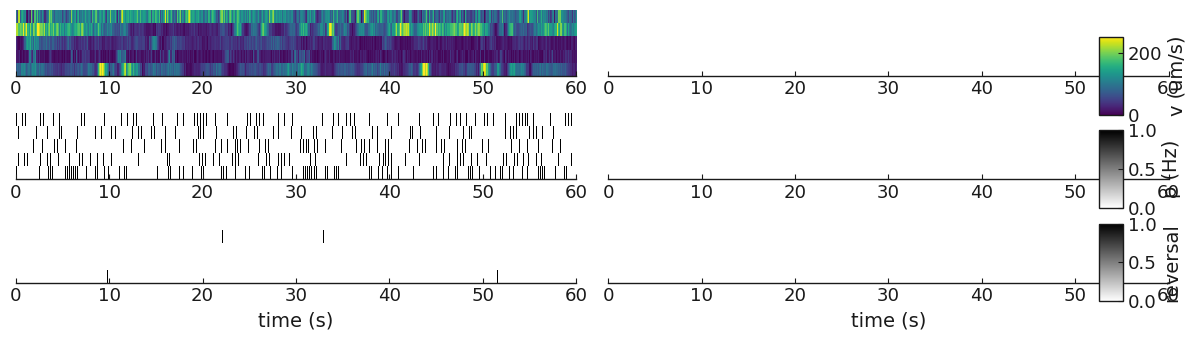

In [200]:
fig, axes = plt.subplots(3,2, figsize=(12,3.5))#, width_ratios=[5,1])
plot, x, y = control.plot(axes[0,0], ('time','velocity'), metric = None, plot_type = 'raster', 
                                  aspect ='auto', vmin=0, vmax = 250, aligned = True, cmap = 'viridis', interpolation='none', extent=(0,60,0,5))#,filterfunction = lambda x:~np.any(np.isnan(x)))
plot1, x, y = control.plot(axes[1,0], ('time','pump_events'), metric = None, plot_type = 'raster', 
                                  aspect ='auto', vmin=0, vmax = 1, aligned = True, cmap = 'gray_r', interpolation='none', extent=(0,60,0,5))#,filterfunction = lambda x:~np.any(np.isnan(x)))
plot2, x, y = control.plot(axes[2,0], ('time','reversals'), metric = None, plot_type = 'raster', 
                                  aspect ='auto', vmin=0, vmax = 1, aligned = True, cmap = 'gray_r', interpolation='none', extent=(0,60,0,5))

fps = 30
plt.setp(axes, xlim = (0,60))
plt.setp(axes[2], xlabel='time (s)')
[style.cleanAxes(ax, where='y') for ax in axes.ravel()];

add_cbar(axes[1,1], plot1[0], 'p (Hz)')
add_cbar(axes[0,1], plot[0], 'v (um/s)')
add_cbar(axes[2,1], plot2[0], 'reversal')
plt.tight_layout()
plt.savefig('figures/Longterm_behavior_1min_ethogram.svg')

In [ ]:
## time align one hour

In [201]:
# time-align all to their starting point
for worm in control.samples:
    worm.create_ID()
    t0 = worm.data.frame.min()
    try:
        #t0 = worm.data.frame[np.where(worm.data.reversal_events_nose==1)[0][0]]
        worm.multi_align(timepoints=[t0], tau_before=0, tau_after=30*60*60, 
                           key = None, column_align = 'frame')
    except IndexError:
        pass

/gpfs/soma_fs/home/scholz/usr/miniconda3/envs/pumping/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


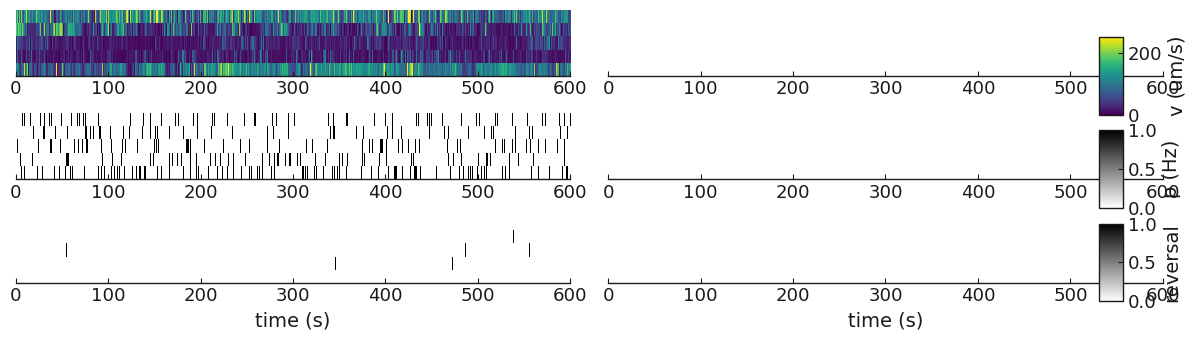

In [205]:
fig, axes = plt.subplots(3,2, figsize=(12,3.5))#, width_ratios=[5,1])
plot, x, y = control.plot(axes[0,0], ('time','velocity'), metric = None, plot_type = 'raster', 
                                  aspect ='auto', vmin=0, vmax = 250, aligned = True, cmap = 'viridis', interpolation='none', extent=(0,3600,0,5))#,filterfunction = lambda x:~np.any(np.isnan(x)))
plot1, x, y = control.plot(axes[1,0], ('time','pump_events'), metric = None, plot_type = 'raster', 
                                  aspect ='auto', vmin=0, vmax = 1, aligned = True, cmap = 'gray_r', interpolation='none', extent=(0,3600,0,5))#,filterfunction = lambda x:~np.any(np.isnan(x)))
plot2, x, y = control.plot(axes[2,0], ('time','reversals'), metric = None, plot_type = 'raster', 
                                  aspect ='auto', vmin=0, vmax = 1, aligned = True, cmap = 'gray_r', interpolation='none', extent=(0,3600,0,5))

fps = 30
plt.setp(axes, xlim = (0,600))
plt.setp(axes[2], xlabel='time (s)')
[style.cleanAxes(ax, where='y') for ax in axes.ravel()];

add_cbar(axes[1,1], plot1[0], 'p (Hz)')
add_cbar(axes[0,1], plot[0], 'v (um/s)')
add_cbar(axes[2,1], plot2[0], 'reversal')
plt.tight_layout()
plt.savefig('figures/Longterm_behavior_10min_ethogram.svg')

/gpfs/soma_fs/home/scholz/usr/miniconda3/envs/pumping/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


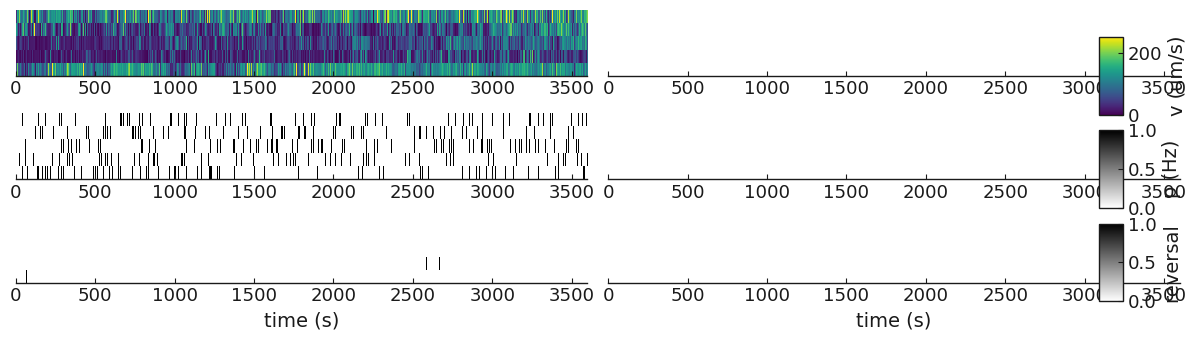

In [207]:
fig, axes = plt.subplots(3,2, figsize=(12,3.5))#, width_ratios=[5,1])
plot, x, y = control.plot(axes[0,0], ('time','velocity'), metric = None, plot_type = 'raster', 
                                  aspect ='auto', vmin=0, vmax = 250, aligned = True, cmap = 'viridis', interpolation='none', extent=(0,3600,0,5))#,filterfunction = lambda x:~np.any(np.isnan(x)))
plot1, x, y = control.plot(axes[1,0], ('time','pump_events'), metric = None, plot_type = 'raster', 
                                  aspect ='auto', vmin=0, vmax = 1, aligned = True, cmap = 'gray_r', interpolation='none', extent=(0,3600,0,5))#,filterfunction = lambda x:~np.any(np.isnan(x)))
plot2, x, y = control.plot(axes[2,0], ('time','reversals'), metric = None, plot_type = 'raster', 
                                  aspect ='auto', vmin=0, vmax = 1, aligned = True, cmap = 'gray_r', interpolation='none', extent=(0,3600,0,5))

fps = 30
plt.setp(axes, xlim = (0,3600))
plt.setp(axes[2], xlabel='time (s)')
[style.cleanAxes(ax, where='y') for ax in axes.ravel()];

add_cbar(axes[1,1], plot1[0], 'p (Hz)')
add_cbar(axes[0,1], plot[0], 'v (um/s)')
add_cbar(axes[2,1], plot2[0], 'reversal')
plt.tight_layout()
plt.savefig('figures/Longterm_behavior_60min_ethogram.svg')

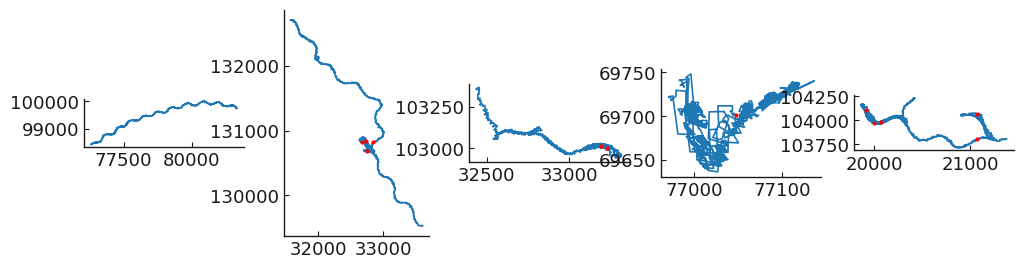

In [149]:
ig, axes = plt.subplots(1,5, figsize=(12,3))
for i in range(5):
    ex = control[i:i+1]
    axes[i].set_aspect(1)
    x= ex.get_sample_metric('x_scaled')[0:fps*60]#, 'y_scaled'), metric = None)
    y= ex.get_sample_metric('y_scaled')[0:fps*60]
    axes[i].plot(x,y)
    reversals = ex.get_sample_metric('reversals')[0:fps*60]
    x1_masked = np.ma.masked_where(reversals.values==0, x)
    y1_masked = np.ma.masked_where(reversals.values==0, y)
    #plot, x1, y1 = ex.plot(axes[0], ('x_scaled', 'y_scaled'), metric = None, color = 'navy', label='example', zorder=-5)
    axes[i].plot(x1_masked, y1_masked, 'red',marker='o', zorder=10, markersize=3)

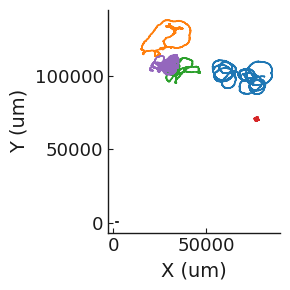

In [75]:
ig, axes = plt.subplots(1,1, figsize=(3,3))
plot, x, y = control.plot(axes, ('x_scaled', 'y_scaled'), metric = None)
# scale bar
lscalebar = 1000#/data[condition].scale/3088 # desired length/scale/100 to get to 0-1 scaling
axes.plot([1500, 1500+lscalebar], [200,200], color = 'k') 

# labelling
plt.setp(axes, ylabel='Y (um)', xlabel = 'X (um)')#, xlim=(0, 14000), ylim=(0, 10000))

plt.tight_layout()

In [ ]:
fig, axes = plt.subplots(1,5, figsize=(12,8))
axes = axes.ravel()
vmax = 200
n = 30*5
for loc, worm in enumerate(control.samples[:20]):
    axes[loc].set_title(worm.experiment, fontsize=8)
    x, y = worm.data.x[::30]/1000, worm.data.y[::30]/1000
    x -= x.mean()
    y -= y.mean()
    v = worm.data.velocity[::30]
    style.multicolor(axes[loc],x,y,None,t=v, c=plt.cm.viridis, 
                     threedim = False, etho = False, cg = 1, vmin = 0, vmax = vmax)
    axes[loc].set_aspect(1)
    # scale bar
    xl = x+10
    yl = y+1
    lscalebar = 10#/data[condition].scale/3088 # desired length/scale/100 to get to 0-1 scaling
    axes[loc].plot([xl, xl+lscalebar], [yl,yl], color = 'k') 

sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=0, vmax=vmax))
plt.colorbar(ax = axes,mappable = sm, label = 'velocity', fraction =0.008)
# labelling - scale bar

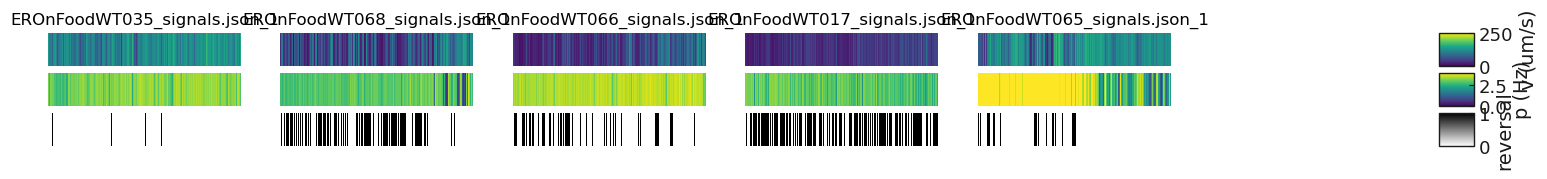

In [134]:
## Figures 

fig, axes = plt.subplots(3,6, figsize=(17.5,1.5))
t0, w = 0, 30*60*60*1
tau = 30*10
for loc, worm in enumerate(control.samples):
    axes[0,loc].set_title(worm.id, fontsize =12)
    tmp = worm.data
    tmp_cg = chunk_mean(tmp, tau)
    tmp_cg_2 = chunk_max(tmp, tau)
    #print(len(tmp_cg))
    plot = axes[0, loc].imshow(tmp_cg['velocity'].values.reshape((1,-1)), aspect ='auto', vmin=0, vmax = 250, cmap = 'viridis', interpolation='nearest')
    plot1 = axes[1, loc].imshow(tmp_cg['count_rate_pump_events'].values.reshape((1,-1)), aspect ='auto', vmin=0, vmax = 4.0, cmap = 'viridis', interpolation='nearest')
    plot2 = axes[2, loc].imshow(tmp_cg_2['reversals'].values.reshape((1,-1)), aspect ='auto', vmin=0, vmax = 1, cmap = 'gray_r', interpolation='none')
add_cbar(axes[1,5], plot1, 'p (Hz)')
add_cbar(axes[0,5], plot, 'v (um/s)')
add_cbar(axes[2,5], plot2, 'reversal')

#axes[2,0].plot([0,60], [0,0], 'r-')
[style.cleanAxes(ax, where='all') for ax in axes.ravel()];
plt.setp(axes, xlim=(0,360));

In [146]:
def CLtrajectory_plotter(CLine, XY, y, cluster_color, cluster_label, figsize=(10,10), fn=''):
    fig, ax = plt.subplots(figsize=(10,10))
    legend_elements = [Line2D([0], [0],color=cluster_color[i], label=cluster_label [i]) for i in cluster_label]
    adjustCL = (CLine-np.nanmean(CLine))+np.repeat(XY.reshape(XY.shape[0],1,XY.shape[1]), CLine.shape[1], axis=1)-np.nanmean(XY, axis=0)# fits better than subtracting 50
    adjustXY = XY-np.nanmean(XY, axis=0)
    for l in np.unique(y).astype(int):
        il = np.where(y == l)[0]
        ax.plot(*adjustCL[il].T, c=cluster_color[l], alpha = 0.1)
            
    ax.set_title(fn)
    ax.axis('equal')
    ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1,1))
    return fig

## Roaming-dwelling ethograms

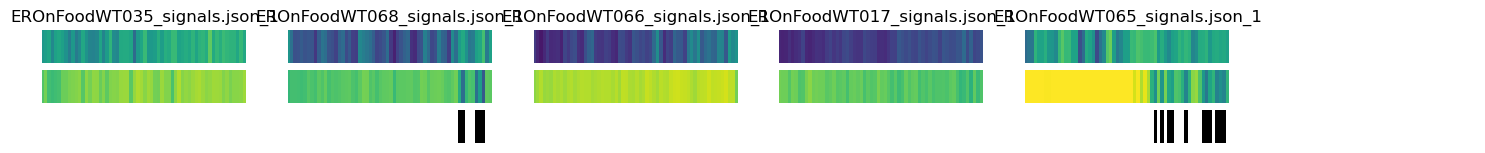

In [100]:
## Figures 

fig, axes = plt.subplots(3,6, figsize=(18.5,1.5))
t0, w = 0, 30*60*60*1
tau = 30*60
for loc, worm in enumerate(control.samples):
    axes[0,loc].set_title(worm.id, fontsize =12)
    tmp = worm.data
    tmp_cg = chunk_mean(tmp, tau)
    plot = axes[0, loc].imshow(tmp_cg['velocity'].values.reshape((1,-1)), aspect ='auto', vmin=0, vmax = 200, cmap = 'viridis', interpolation='nearest')
    plot1 = axes[1, loc].imshow(tmp_cg['count_rate_pump_events'].values.reshape((1,-1)), aspect ='auto', vmin=0, vmax = 4.0, cmap = 'viridis', interpolation='nearest')
    plot2 = axes[2, loc].imshow(tmp_cg['count_rate_pump_events'].values.reshape((1,-1))>2.5, aspect ='auto', vmin=0, vmax = 1, cmap = 'gray', interpolation='none')
# add_cbar(axes[1,5], plot1, 'p (Hz)')
# add_cbar(axes[0,5], plot, 'v (um/s)')
# add_cbar(axes[2,5], plot2, 'on/off')

#axes[2,0].plot([0,60], [0,0], 'r-')
[style.cleanAxes(ax, where='all') for ax in axes.ravel()];
plt.setp(axes, xlim=(0,60));

IndexError: index 4 is out of bounds for axis 0 with size 4

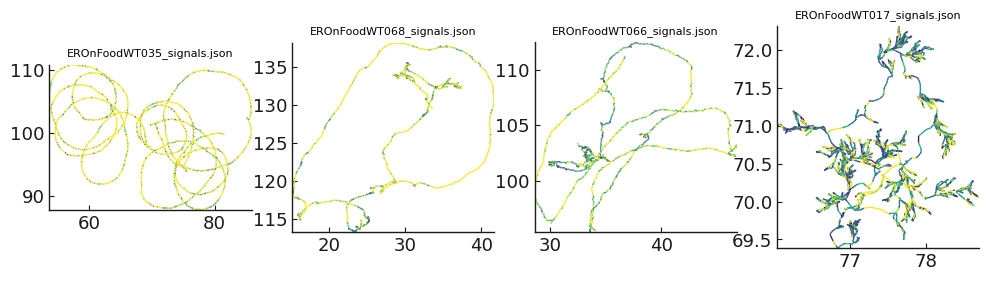

In [26]:
examples = control

fig, axes = plt.subplots(1,4, figsize=(12,8))
axes = axes.ravel()
vmax = 100
n = 30*5
for loc, worm in enumerate(control.samples[:20]):
    axes[loc].set_title(worm.experiment, fontsize=8)
    style.multicolor(axes[loc],worm.data.x[::30]/1000, worm.data.y[::30]/1000,None,t=worm.data.velocity[::30], c=plt.cm.viridis, 
                     threedim = False, etho = False, cg = 1, vmin = 0, vmax = vmax)
    axes[loc].set_aspect(1)
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=0, vmax=vmax))
plt.colorbar(ax = axes,mappable = sm, label = 'pumping rate (Hz)', fraction =0.008)
# labelling - scale bar

#plt.setp(axes, ylabel='Y (px)', xlabel = 'X (px)', xlim=(0, 3088), ylim=(0, 2084))
#plt.setp(axes, ylabel='Y (px)', xlabel = 'X (px)', xlim=(0, 3088), ylim=(0, 2084));

## Example worm 1h

NameError: name 'ex' is not defined

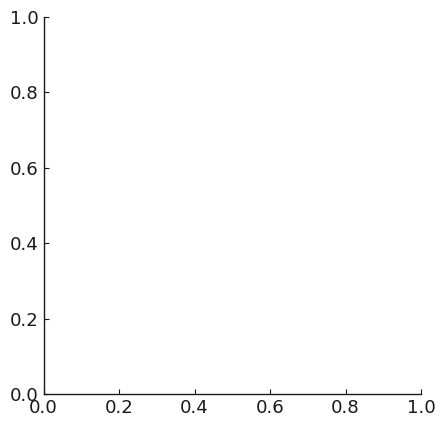

In [27]:
## Example worm
fig, ax = plt.subplots(1,1, figsize=(12,5))
ax.set_aspect(1)

#
time = ex.samples[0].data.time[::30]/60
vmax = max(time)
ex = control[5:6]
plot, x1, y1 = ex.plot(ax, ('x_scaled', 'y_scaled'), metric = None, color = 'navy', label='example', zorder=-5)
style.multicolor(ax,x1[::30].values, y1[::30].values,None,t=time, c=plt.cm.viridis, 
                     threedim = False, etho = False, cg = 1)
print(len(x1))

# scale bar
# add a scalebar
scale = 1000 #(mm/px)
scalebar = 5 # mm
l = scalebar/scale

xmax = ax.get_xlim()[1]
print(ax.get_ylim())
#ax.hlines(ax.get_ylim()[0]+50, xmax-l-50, xmax-50, color = 'k', zorder=10)
ax.plot([60000, 70000], [180000, 180000], 'k-')
# labelling
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=0, vmax=vmax))
plt.colorbar(ax = ax,mappable = sm, label = 'time (min)', fraction =0.03)
plt.setp(ax, ylabel='Y (um)', xlabel = 'X (um)')#, xlim=(0, 3088*scale), ylim=(0, 2064*scale))
plt.tight_layout()
#plt.savefig('Example_trajectory_1h.svg')

ValueError: No objects to concatenate

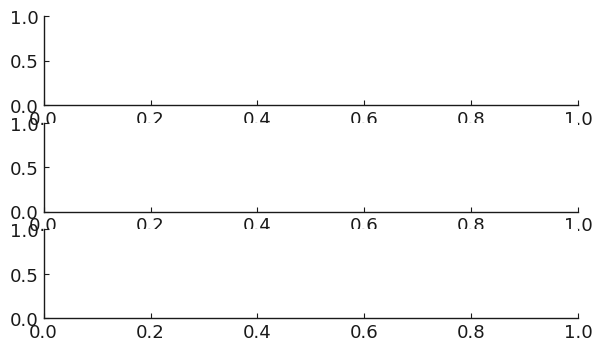

In [112]:
fig, axes = plt.subplots(3,1, figsize=(6/0.87,4))
t0, w = 0, 30*60*60
#im = axes[0].imshow(distance[np.newaxis,:], vmin=0, vmax = 5,  cmap = 'coolwarm', interpolation='nearest', aspect='auto')
#add_cbar(axes[0], im, 'd (mm)')

plot, x, y = ex.plot(axes[0], ('time','reversals_nose'), metric = None, plot_type = 'raster', 
                                  aspect ='auto', vmin=0, vmax = 1, aligned = True, cmap = 'gray_r', interpolation='None')#,filterfunction = lambda x:~np.any(np.isnan(x)))

plot, x, y = ex.plot(axes[1], ('time','count_rate_pump_events_smooth'), metric = None, plot_type = 'raster', 
                                  aspect ='auto', vmin=0, vmax = 4, aligned = True, cmap = 'viridis', interpolation='nearest')#,filterfunction = lambda x:~np.any(np.isnan(x)))
add_cbar(axes[1], plot[0], 'p (Hz)')
plot, x, y = ex.plot(axes[2], ('time','velocity_smooth'), metric = None, plot_type = 'raster', 
                                  aspect ='auto', vmin=0, vmax = 150, aligned = True, cmap = 'viridis', interpolation='nearest')#,filterfunction = lambda x:~np.any(np.isnan(x)))

add_cbar(axes[2], plot[0], 'v (um/s)')
plt.setp(axes, ylabel='metric (a.u.)', xlim=(t0,t0+w));
#plt.tight_layout()
[style.cleanAxes(ax, where='x') for ax in axes]
#plt.savefig('Figures/Mating_overview_1h.svg')


[None, None, None]

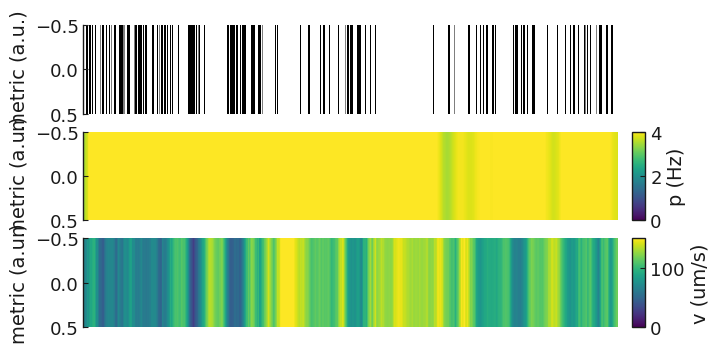

In [112]:
fig, axes = plt.subplots(3,1, figsize=(6/0.87,4))
t0, w = 0, 30*60*10
#im = axes[0].imshow(distance[np.newaxis,:], vmin=0, vmax = 5,  cmap = 'coolwarm', interpolation='nearest', aspect='auto')
#add_cbar(axes[0], im, 'd (mm)')

plot, x, y = ex.plot(axes[0], ('time','reversals_nose'), metric = None, plot_type = 'raster', 
                                  aspect ='auto', vmin=0, vmax = 1, aligned = True, cmap = 'gray_r', interpolation='None')#,filterfunction = lambda x:~np.any(np.isnan(x)))

plot, x, y = ex.plot(axes[1], ('time','count_rate_pump_events_smooth'), metric = None, plot_type = 'raster', 
                                  aspect ='auto', vmin=0, vmax = 4, aligned = True, cmap = 'viridis', interpolation='nearest')#,filterfunction = lambda x:~np.any(np.isnan(x)))
add_cbar(axes[1], plot[0], 'p (Hz)')
plot, x, y = ex.plot(axes[2], ('time','velocity_smooth'), metric = None, plot_type = 'raster', 
                                  aspect ='auto', vmin=0, vmax = 150, aligned = True, cmap = 'viridis', interpolation='nearest')#,filterfunction = lambda x:~np.any(np.isnan(x)))

add_cbar(axes[2], plot[0], 'v (um/s)')
plt.setp(axes, ylabel='metric (a.u.)', xlim=(t0,t0+w));
#plt.tight_layout()
[style.cleanAxes(ax, where='x') for ax in axes]

NameError: name 'add_cbar' is not defined

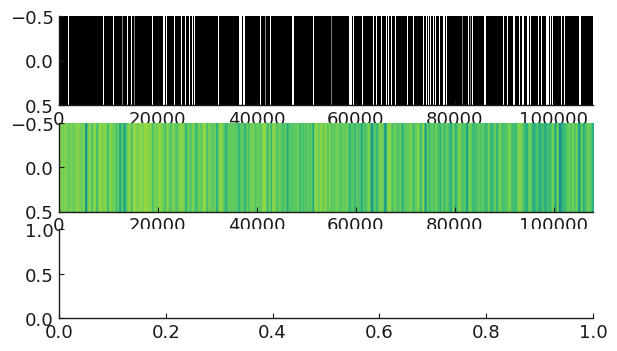

In [119]:
fig, axes = plt.subplots(3,1, figsize=(6/0.87,4))
t0, w = 0, 30*60*1
#im = axes[0].imshow(distance[np.newaxis,:], vmin=0, vmax = 5,  cmap = 'coolwarm', interpolation='nearest', aspect='auto')
#add_cbar(axes[0], im, 'd (mm)')

plot, x, y = ex.plot(axes[0], ('time','reversals_nose'), metric = None, plot_type = 'raster', 
                                  aspect ='auto', vmin=0, vmax = 1, aligned = True, cmap = 'gray_r', interpolation='None')#,filterfunction = lambda x:~np.any(np.isnan(x)))

plot, x, y = ex.plot(axes[1], ('time','count_rate_pump_events_smooth'), metric = None, plot_type = 'raster', 
                                  aspect ='auto', vmin=0, vmax = 4, aligned = True, cmap = 'viridis', interpolation='nearest')#,filterfunction = lambda x:~np.any(np.isnan(x)))
add_cbar(axes[1], plot[0], 'p (Hz)')
plot, x, y = ex.plot(axes[2], ('time','velocity_smooth'), metric = None, plot_type = 'raster', 
                                  aspect ='auto', vmin=0, vmax = 150, aligned = True, cmap = 'viridis', interpolation='nearest')#,filterfunction = lambda x:~np.any(np.isnan(x)))

add_cbar(axes[2], plot[0], 'v (um/s)')
plt.setp(axes, ylabel='metric (a.u.)', xlim=(t0,t0+w));
#plt.tight_layout()
[style.cleanAxes(ax, where='x') for ax in axes]

(69233.3394033269, 72462.63334995961)
(69312.63053929944, 70797.51949453626)
(69556.97944016008, 69728.68732972252)


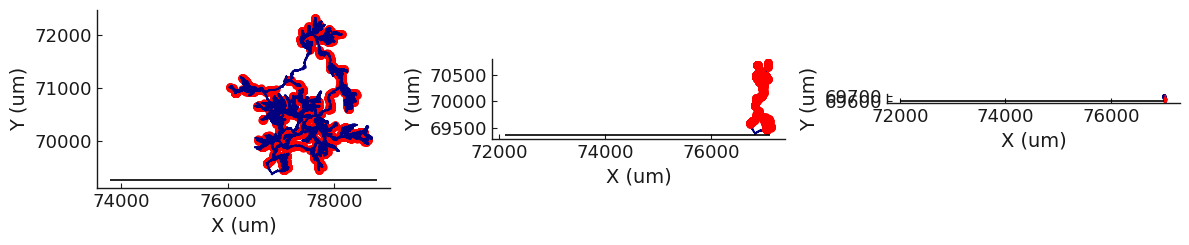

In [118]:
ex = control[3]

fig, axes = plt.subplots(1,3, figsize=(12,5))
offset = 5*30*60 # start at 5 min
for ax in axes:
    ax.set_aspect(1)
plot, x1, y1 = ex.plot(axes[0], ('x_scaled', 'y_scaled'), metric = None, color = 'navy', label='example', zorder=5)
# generate the tracks where reversals are
reversals = ex.get_sample_metric('reversals_nose')
x1_masked = np.ma.masked_where(reversals.values==1, x1)
y1_masked = np.ma.masked_where(reversals.values==1, y1)

plot, x1, y1 = ex.plot(axes[0], ('x_scaled', 'y_scaled'), metric = None, color = 'navy', label='example', zorder=-5)
axes[0].plot(x1_masked, y1_masked, 'red',marker='o')

axes[1].plot(x1[offset:30*60*10+offset], y1[offset:30*60*10+offset], color = 'navy')
axes[1].plot(x1_masked[offset:30*60*10+offset], y1_masked[offset:30*60*10+offset], 'red', marker='o')

axes[2].plot(x1[offset:30*60+offset], y1[offset:30*60+offset], color = 'navy')
axes[2].plot(x1_masked[offset:30*60*1+offset], y1_masked[offset:30*60*1+offset], 'red')

# scale bar
# add a scalebar
scale = ex.scale/1000 #(mm/px)
scalebar = 5 # mm
l = scalebar/scale
for ax in axes:
    xmax = ax.get_xlim()[1]
    print(ax.get_ylim())
    ax.hlines(ax.get_ylim()[0]+50, xmax-l-50, xmax-50, color = 'k', zorder=10)

# labelling
plt.setp(axes, ylabel='Y (um)', xlabel = 'X (um)')#, xlim=(0, 3088*scale), ylim=(0, 2064*scale))
plt.tight_layout()
#plt.savefig('Figures/Mating_trajectories.svg')



In [ ]:
plt.plot(reversals)

In [ ]:
x1_masked = np.ma.masked_where(reversals.values==0, x1)
y1_masked = np.ma.masked_where(reversals.values==0, y1)

In [ ]:
plt.plot(x1_masked, y1_masked)

In [ ]:
x1.iloc[np.where(reversals==1)

In [ ]:
plt.plot(reversals==1)

0.009240670206578231 0.7677918081693154
0.008561803190202319 0.94360377463845
0.01785482525261889 0.9892185037545191
0.026281172416348617 0.9885778337718163
0.007259510908245476 0.8307632450488237


ValueError: No objects to concatenate

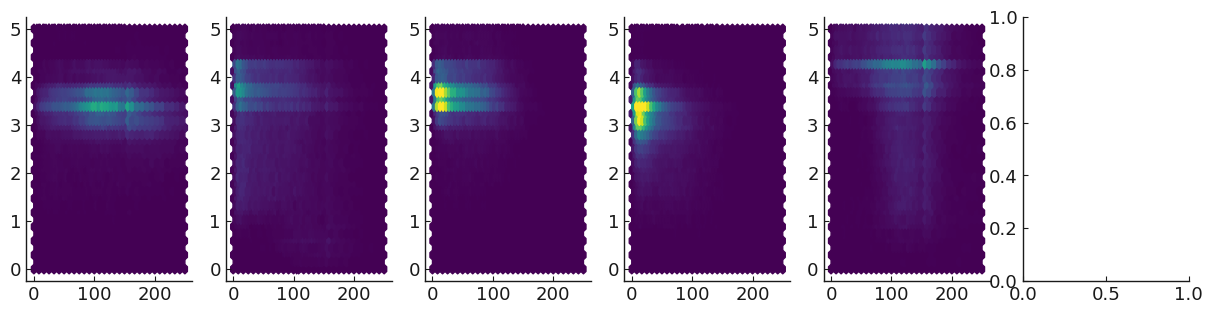

In [111]:
cm = plt.cm.viridis
fig, axes = plt.subplots(1,6, figsize=(15,3.5))
#axes = axes.ravel()
#axes = [axes]
vmax = 0.015
for loc in range(6):
    
    #for experimentID in experiment:

    #plot, x, y = data[condition][:].plot(axes, ('velocity', 'count_rate'), metric = 'collapse', plot_type = 'scatter',alpha=0.001 )
    x = control[loc:loc+1].get_sample_metric('velocity', metric = 'collapse', axis=0)
    y = control[loc:loc+1].get_sample_metric('rate', metric = 'collapse', axis=0)

    # clean nans in the data
    tmp = pd.concat([x, y], axis=1)
    tmp = tmp.dropna()


    #axes[loc].plot(x[::30], y[::30], '^', alpha=0.05)
    hb = axes[loc].hexbin(tmp.iloc[:,0], tmp.iloc[:,1], extent = [0,250,0,5], gridsize=30)
    hb = axes[loc].hexbin(tmp.iloc[:,0], tmp.iloc[:,1], C=np.ones(len(tmp), dtype=float)/hb.get_array().sum(), 
                          extent = [0,150,0,5], gridsize=30, cmap=cm, reduce_C_function=np.sum, vmax = vmax, vmin =0)
    print(hb.get_array()[20:-20].max(), hb.get_array().sum())
    # normalize

    #axes[loc].plot(x.mean(), y.mean(), 'ro', markersize=3)
    #axes[loc].errorbar(x.mean(), y.mean(), xerr = x.std(), yerr= y.std(), markersize=10,color = 'w')
    #plot, x, y = data[condition][:100].plot(axes, ('velocity', 'count_rate'), metric = 'mean', plot_type = 'scatter')
    #slope, intercept, r_value, p_value, stderr= stats.linregress(x=x[::30].values[:,0], y=y[::30].values[:,0])
    #print(condition, 'R=',f'{r_value**2:.2f}')
ax = axes[-1]
cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.02,ax.get_position().height])
cbar = plt.colorbar(hb, cax=cax, ticks=[0,  vmax]) # Similar to fig.colorbar(im, cax = cax)

plt.setp(axes[::2],  ylabel='pumping rate (Hz)', xlim=(0,150), ylim=(0,5));
plt.setp(axes[-2:], xlabel='velocity (um/s)', xlim=(0,150), ylim=(0,5));
plt.setp(axes,xlim=(0,250), ylim=(0,5), yticks=[0,2.5,5]);
#fig.colorbar(cbar, ticks=[0,  vmax])
cbar.ax.set_yticklabels(['0',  f'> {vmax}'])  # vertically oriented colorbar

#plt.savefig('Figures/Mating_behavior_correlation_1s_dt.svg')

In [31]:
ex

Experiment 
 Strain: INF418,
 Condition: OnFood
 N = 1.